<a href="https://colab.research.google.com/github/samanthaernst/CS-410-Course-Project/blob/main/CS_410_Course_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [286]:
# URL of the post
url = "https://www.reddit.com/r/AmItheAsshole/comments/bjd41e/aita_for_throwing_away_my_boyfriends_potentially/"

In [173]:
# necessary installs
%pip install praw
%pip install NRCLex
!pip install --quiet python-dotenv

In [227]:
# get client_id, client_secret, and user_agent for PRAW authentication from google drive .env file
from google.colab import drive
import dotenv
import os
import praw

drive.mount('/content/drive')
dotenv.load_dotenv('/content/drive/MyDrive/.env') # put .env file location here
client_id = os.getenv('client_id')
client_secret = os.getenv('client_secret')
user_agent = os.getenv('user_agent')

reddit = praw.Reddit(client_id=client_id,
                     client_secret=client_secret,
                     user_agent=user_agent)

In [228]:
# to track polarity of the contexts of each word
class WordPolarity:

    def __init__(self, total, count):
        self.total = total
        self.count = count

In [259]:
# utility functions
import unicodedata
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
judgements = ["NTA", "YTA", "NAH", "ESH", "YWBTA", "YWNBTA", "INFO"]

# tokenize, clean up punctuation, remove stop words, etc. from text
def clean_up(text):
  meaningful_words = []

  string = unicodedata.normalize('NFKD', text)\
             .encode('ascii', 'ignore')\
             .decode('utf-8', 'ignore')
  string = re.sub(r'[^\w\s]', '', string).lower()

  tokenized = sent_tokenize(string)

  for i in tokenized:
    # find the words and punctuation in string
    words_list = [word.lower() for word in nltk.word_tokenize(i)]

    # removing stop words
    meaningful_words += [w for w in words_list if not w in stop_words]

    wnl = nltk.stem.WordNetLemmatizer()

    # use the lemmatizer on each word
    meaningful_words = [wnl.lemmatize(word) for word in meaningful_words]

    # remove judgements from words
    meaningful_words  = [word for word in meaningful_words if not word.upper() in judgements]

  return meaningful_words

# takes list of words, returns only the adjectives
def get_adj(tagged_words):
    return [ word for (word,tag) in tagged_words if tag.startswith("JJ")]

# takes list of words, returns adjectives, nouns, adverbs, and verbs
def get_main_words(tagged_words):
    return [ word for (word,tag) in tagged_words if tag.startswith("JJ") or tag.startswith('NN') or tag.startswith('RB') or tag.startswith('VB')]

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [287]:
# go through comments to get words and judgements
from praw.models import MoreComments
import re
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')

# creating a submission object
submission = reddit.submission(url=url)

comments_processed = 0
comment_words = []
post_comment_adjectives = {}
judgements = ["NTA", "YTA", "NAH", "ESH", "YWBTA", "YWNBTA", "INFO"]
post_judgement_counts = {"NTA": 0, "YTA": 0, "NAH": 0, "ESH": 0, "YWBTA": 0, "YWNBTA": 0, "INFO": 0}
word_polarities = {}
word_cloud_text = []

for comment in submission.comments[1:]:
    if type(comment) == MoreComments:
        continue
    if any(judgement in comment.body for judgement in judgements):
      comments_processed += 1

      # count which judgement this comment voted for
      for judgement in judgements:
        if judgement in comment.body:
          j = judgement
          break

      comment_words = clean_up(comment.body)

      tagged = nltk.pos_tag(comment_words)

      comment_words = get_main_words(tagged)

      word_cloud_text += comment_words

      # use sentiment analyzer to get polarity scores for this comment as a whole
      sia = SentimentIntensityAnalyzer()
      comment_polarities = sia.polarity_scores(comment.body)

      # add this to polarity scores for individual words (context-based)
      for word in comment_words:
        if word in word_polarities:
          word_polarities[word].total += comment_polarities['compound']
          word_polarities[word].count += 1
        else:
          word_polarities.update({word: WordPolarity(comment_polarities['compound'], 1)})

      comment_adjectives = get_adj(tagged)

      for word in comment_adjectives:
        post_comment_adjectives[word] = post_comment_adjectives.get(word, 0) + 1

      post_judgement_counts[j] += 1 + comment.score

# remove words from original post and title, and some other common words with meaning that is difficult to determine without context
disregard_words = set(['good', 'asshole'])

disregard_words.update(clean_up(submission.title))

basic_colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple', 'pink', 'brown', 'black', 'white', 'gray']
disregard_words.update(basic_colors)

disregard_words.update(clean_up(submission.selftext))

# commonly repeated, often taken out of context when analyzing individual words
for word in disregard_words:
  if word in post_comment_adjectives.keys():
    del post_comment_adjectives[word]

print("post title: " + submission.title)
print(str(len(submission.comments[1:])) + " total comments")
print(str(comments_processed) + " processed with judgements")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



post title: AITA for Throwing Away my Boyfriend's Potentially Illegal Yogurt Collection?
210 total comments
156 processed with judgements


<IPython.core.display.Javascript object>

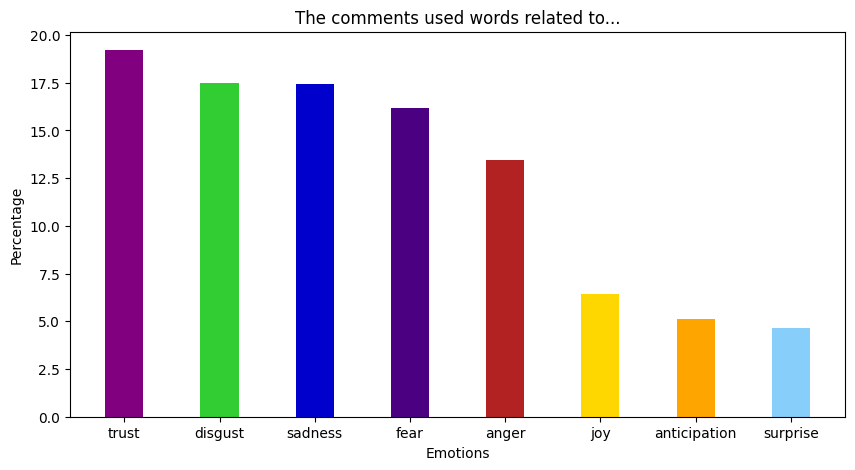

Top words for each category:

Trust
         Word    Trust  Freq
 professional 0.500000    10
        clean 0.333333     6
      general 0.500000     2
       stable 0.500000     2
          top 0.333333     3
       intend 1.000000     1
        proxy 1.000000     1
      suggest 1.000000     1
understanding 0.500000     1
       intact 0.500000     1


Disgust
   Word  Disgust  Freq
  gross 0.500000     3
   shit 0.333333     4
  messy 0.500000     2
  trash 0.333333     3
dispose 1.000000     1
   nose 1.000000     1
    mad 0.200000     3
 unfair 0.250000     2
    ill 0.200000     2
  nasty 0.200000     2


Sadness
      Word  Sadness  Freq
     worse 0.333333     8
   refused 0.500000     3
 concerned 0.500000     2
     trash 0.333333     3
       mad 0.200000     3
    unfair 0.250000     2
       ill 0.200000     2
     nasty 0.200000     2
impossible 0.500000     1
     tough 0.500000     1


Fear
     Word     Fear  Freq
    worse 0.333333     8
ultimatum 0.333333     7
conc

In [288]:
# get emotions related to words using NRCLex, display top emotions related to words in comments
from nrclex import NRCLex
import pandas as pd
import math
from matplotlib import pyplot as plt
import numpy as np

counts = post_comment_adjectives.values()
sorted_comment_words = dict(sorted(post_comment_adjectives.items(), key=lambda x:x[1], reverse=True))

word_emotions = []

comment_emotions = {"fear": 0, "anger": 0, "anticipation": 0, "trust": 0, "surprise": 0, "sadness": 0, "disgust": 0, "joy": 0}

for word, freq in sorted_comment_words.items():

    # creating objects
    emotion = NRCLex(word)

    emotions_arr = emotion.top_emotions

    # create array of arrays that each contain a word, its values for each emotion, and its frequency
    top_emotions = dict(emotions_arr)
    this_emotions = []
    has_emotion = False
    for x, y in comment_emotions.items():

      # check if emotions_arr has this emotion x
      if x in top_emotions:
        if top_emotions[x] > 0:
          has_emotion = True
        this_emotions.append(top_emotions[x])
      else:
        this_emotions.append(0)

    if has_emotion:
      weight = math.log(1 + freq / max(sorted_comment_words.values())) + (0.1 if freq > 1 else 0)
      word_emotions.append([word] + this_emotions + [freq] + [weight] + [nltk.pos_tag([word])[0]])

    # sum up top emotions. weight by log of frequency
    for emotion, decimal in emotions_arr:
      emotion = "anticipation" if emotion == "anticip" else emotion
      if emotion == 'positive' or emotion == 'negative': continue
      # if freq > 1:
      comment_emotions[emotion] += decimal * (math.log(1 + freq / max(sorted_comment_words.values())) + (0.1 if freq > 1 else 0))

# dataframe to show emotion values for each word and frequency of words
# should only be adjectives. emotion values will be weighted by frequency of use in comments
emotions_columns = ['Word', 'Fear', 'Anger', 'Anticipation', 'Trust', 'Surprise', 'Sadness', 'Disgust', 'Joy', 'Freq', 'Weight', 'POS Tag']
words_info = pd.DataFrame(word_emotions, columns= emotions_columns)

# disable auto-scroll of large output
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

colors = {"fear": 'indigo', "anger": 'firebrick', "anticipation": 'orange', "surprise": 'lightskyblue', "sadness": 'mediumblue', "disgust": 'limegreen', "joy": 'gold', "trust": 'purple'}

total = sum(comment_emotions.values(), 0.0)
emotion_percentages = {k: v / total * 100 for k, v in comment_emotions.items()}
percentages = emotion_percentages.values()
sorted_emotion_percentages = dict(sorted(emotion_percentages.items(), key=lambda x:x[1], reverse=True))

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(sorted_emotion_percentages.keys(), sorted_emotion_percentages.values(), color = [colors[key] for key in sorted_emotion_percentages.keys()],
        width = 0.4)

plt.xlabel("Emotions")
plt.ylabel("Percentage")
plt.title('The comments used words related to...')
plt.show()

# print out max top 10 words related to each emotion
print('\033[4m' + '\033[1m' + "Top words for each category:\n" + '\033[0m')
for emotion in [emotion.capitalize() for emotion in sorted_emotion_percentages.keys()]:
  print('\033[1m' + emotion + '\033[0m')
  emotion_df = words_info.loc[(words_info[emotion] > 0), ['Word', emotion, 'Freq', 'Weight']]

  sorted_indices = (emotion_df[emotion] * emotion_df["Weight"]).sort_values(ascending = False).index
  sorted_emotion_df = emotion_df.loc[sorted_indices, :]

  print(sorted_emotion_df[:10][['Word', emotion, 'Freq']].to_string(index=False))
  print('\n')

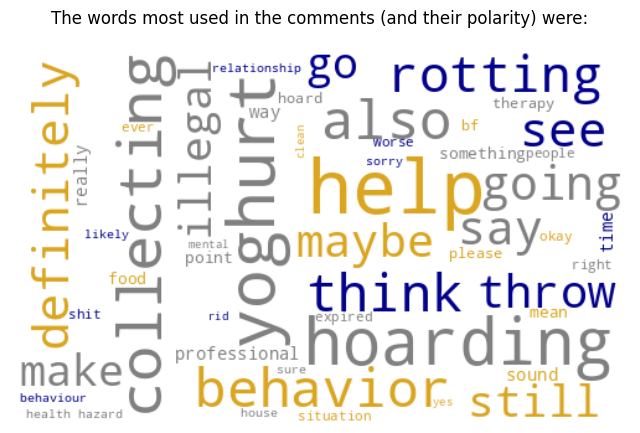

In [293]:
# display word cloud of most frequently used words in comments, where color corresponds to polarity of word context
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

def polarity_to_color(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    words = word.split()

    total_count = 0
    for word in words:
      total_count += word_polarities[word].count

    avg_polarity = 0
    for word in words:
      avg_polarity += word_polarities[word].total / total_count

    if avg_polarity > 0.15: # notably positive context
      return "goldenrod"
    elif avg_polarity < -0.15: # notably negative context
      if sorted_emotion_percentages["sadness"] > sorted_emotion_percentages["anger"]:
        return "darkblue"
      else:
        return "darkred"
    else:
      return "grey" # fairly neutral or controversial context

# create and generate a word cloud image:
disregard = set(['im', 'id', 'u', 'youre', 'ah', 'asshole', 'good', 'cant', 'thats', 'wouldnt', 'shouldnt', 'dont', 'doesnt', 'couldnt', 'arent', 'didnt', 'isnt', 'wasnt', 'shes', 'hes', 'theyre', 'youve', 'theyve'])
disregard.update(clean_up(submission.selftext))
wordcloud = WordCloud(max_font_size=60, max_words=50, width = 500, height = 300, stopwords=disregard, background_color="white").generate(' '.join(word_cloud_text))

# display the generated image:
plt.figure(figsize=[8,15])
plt.imshow(wordcloud.recolor(color_func=polarity_to_color), interpolation='bilinear')
plt.title('The words most used in the comments (and their polarity) were:', pad=20)
plt.axis("off")
plt.show()

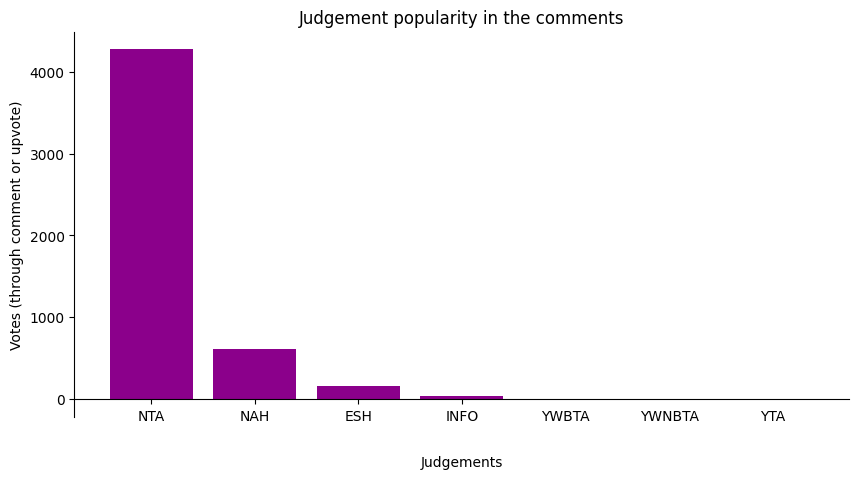

In [296]:
# display bar graph of judgement popularity (allows for negative popularity due to downvotes)
import matplotlib.pyplot as plt
from numpy import array

counts = post_judgement_counts.values()
sorted_judgement_counts = dict(sorted(post_judgement_counts.items(), key=lambda x:x[1], reverse=True))

fig = plt.figure(figsize = (10, 5))

y_pos = np.arange(len(sorted_judgement_counts.values()))

plt.bar(y_pos, sorted_judgement_counts.values(), align='center', color = 'darkmagenta')
plt.xticks(y_pos, sorted_judgement_counts.keys())
plt.ylabel("Votes (through comment or upvote)")
plt.title('Judgement popularity in the comments')

# set up axes so that bars can display negative values
ax = plt.gca()
ax.set_xticklabels([])
ax.set_xticks([idx for (idx, x) in enumerate(sorted_judgement_counts.values()) if x > 0])
ax.spines["bottom"].set_position(("data", 0))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
label_offset = max(sorted_judgement_counts.values()) * 0.03
for language, (x_position, y_position) in zip(sorted_judgement_counts.keys(), enumerate(sorted_judgement_counts.values())):
    if y_position > 0:
        label_y = -label_offset
    else:
        label_y = y_position - label_offset
    ax.text(x_position, label_y, language, ha="center", va="top")
ax.text(0.5, -0.1, "Judgements", ha="center", va="top", transform=ax.transAxes)

plt.show()